This notebook works through and demonstrates the SOX stomatal conductance model.

In [1]:
from profit_optimisation_model.src.vapour_pressure_deficit_calculation import vapour_pressure_deficit, saturation_vapour_pressure
from profit_optimisation_model.src.HydraulicConductanceModels.SOX_hydraulic_conductance_model import SOXHydraulicConductanceModel
from profit_optimisation_model.src.HydraulicConductanceModels.cumulative_Weibull_distribution_model import CumulativeWeibullDistribution
from profit_optimisation_model.src.leaf_air_coupling_model import LeafAirCouplingModel
from profit_optimisation_model.src.rubisco_CO2_and_O_model import RubiscoRates
from profit_optimisation_model.src.electron_transport_rate_model import ElectronTransportRateModel
from profit_optimisation_model.src.michaelis_menten_response_function import michaelis_menten_constant

# -- Temperature dependency models --
from profit_optimisation_model.src.TemperatureDependenceModels.arrhenius_and_peaked_arrhenius_function import PeakedArrheniusModel, ArrheniusModel
from profit_optimisation_model.src.TemperatureDependenceModels.Q10_temperature_dependence_model import Q10TemperatureDependenceModel
from profit_optimisation_model.src.TemperatureDependenceModels.temperature_dependence_model import LowTemperatureAdjustedModel

# -- Photosynthesis models --
from profit_optimisation_model.src.PhotosynthesisModels.photosynthesis_model import PhotosynthesisModel
from profit_optimisation_model.src.PhotosynthesisModels.Leuning_Model import PhotosynthesisModelRubiscoLimitedLeuning as PhotosynthesisModelRubiscoLimited
from profit_optimisation_model.src.PhotosynthesisModels.Leuning_Model import PhotosynthesisModelElectronTransportLimitedLeuning as PhotosynthesisModelElectronTransportLimited

# -- CO2 gain models --
from profit_optimisation_model.src.ProfitModels.CO2GainModels.CO2_gain_SOX_model import SOXCO2GainModel
from profit_optimisation_model.src.ProfitModels.CO2GainModels.CO2_gain_profit_max_model import ProfitMaxCO2GainModel

# -- Hydraulic cost models --
from profit_optimisation_model.src.ProfitModels.HydraulicCostModels.hydraulic_cost_SOX_model import SOXHydraulicCostModel
from profit_optimisation_model.src.ProfitModels.HydraulicCostModels.hydraulic_cost_profit_max_model import ProfitMaxHydraulicCostModel

# -- Profit models --
from profit_optimisation_model.src.ProfitModels.SoxModel import SOXModel
from profit_optimisation_model.src.ProfitModels.profit_max_model import ProfitMaxModel

from profit_optimisation_model.src.conversions import (magnitude_conversion,
                                                       mole_carbon_to_grams,
                                                       per_day_to_per_second,
                                                       per_second_to_per_half_hour,
                                                       convert_transpiration_rate_to_latent_energy,
                                                       short_wave_to_photosynthetically_active_radiation,
                                                       light_energy_in_joules_to_micro_moles_of_light,
                                                       degrees_kelvin_to_centigrade,
                                                       degrees_centigrade_to_kelvin,
                                                       convert_stomatal_conductance_of_carbon_to_water)

from xarray import open_dataset
from pandas import DataFrame, date_range
from numpy import nan, linspace, nanargmax, nanmax

from matplotlib import pyplot as plt


# The Model

The core principle of the SOX model is that the plant acts to maximise the product of its photosynthesic rate and the xylem hydraulic conductance. Specificaly it varies the stomatal conductance to water to maximise the following,

$$ A_{net}(g_{sw})k(g_{sw})$$

where $A_{net}(g_{sw})$ is the net carbon uptake due to photosynthesis and $k(g_{sw})$ is the normalised hydraulic conductance. 

The method used to solve for this probelm isthe same steps as those used for the profit max model. We start by defining a set of leaf water potentials ($\psi_l$) from which we can calculate $k(\psi_{l})$ using a conductance model. Next the transpiration rate is calculated by seting it equal to of flow of water from the roots to the leaves, given by the integral of the conductance from the soil water potential to the leaf water potential.

$$ E = \int_{\psi_s}^{\psi_l} k(\psi) d\psi$$

Assuming perfect coupling between the leaf and atmostpher the stomatal conductance to water is then given by dividing the transpiration rate by the atmostpheric VPD,

$$ g_{sw} = \frac{E}{e_{sat}(T) - e} $$

Multiplying this by $1.57$ gives the stomatal conductance to carbon that we need to calculate the internal CO2 concentration using the same quadratic equaitions outlined in the profit max notebook. For rubisco limited photosynthesis the quadratic is

$$ -g_{lc} c_i^2 + ((c_a - k) g_{lc} + R_d - V_{cmax}) c_i + ((c_a g_{lc} + R_d)k + \Gamma^* V_{c \text{max}}) = 0 $$

For electron transport limited photosynthesis the quadratic takes the form

$$ -g_{lc}c_i^2 + (c_ag_{lc} + R_n - 2g_{lc}\Gamma^* - J)c_i + (2c_ag_{lc}\Gamma + 2R_n\Gamma^*+\Gamma^*J) = 0 $$

Given the intercellular CO2 concentration, $c_i$, for each leaf water potential, the net CO2 uptake is given by

$$ A_{net} = (c_a - c_i)g_{sc} $$

Where $c_a$ is the atmospheric CO2 concentration and $g_{sc}$ is the stomatal conductance to CO2.

Before we can impliment this method we need to define the conductance model used by SOX.

# Conductance Model

The conductance model used by SOX differs from that used in the profit max model, taking the form,

$$k(\psi) = \frac{k_{max}}{1 + (\psi / \psi_{50})^a}$$

Here $k_{max}$ is the maximum conductance, $\psi$ is the water potential, $\psi_{50}$ is the leaf water potential when the conductance is half its maximum and $a$ is a shape paramiter. This can be converted to the normalised conductance by removing $k_{max}$.

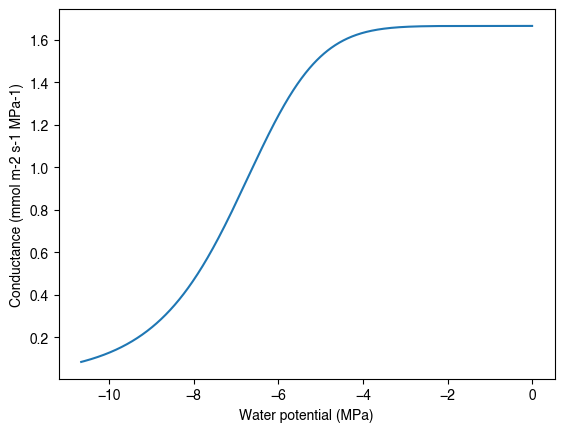

In [2]:
k_max = 1.6659 # mmol m-2 s-1 MPa-1
water_potential_at_half_conductance = -7 # MPa
shape_parameter = 7

# Model setup
SOX_hydraulic_conductance_model = SOXHydraulicConductanceModel(k_max, water_potential_at_half_conductance, shape_parameter)

# Setup leaf water potentials
critical_conductance_fraction = 0.95
SOX_critical_water_potential = SOX_hydraulic_conductance_model.water_potential_from_conductivity_loss_fraction(critical_conductance_fraction)
SOX_water_potentials = linspace(0, SOX_critical_water_potential, 1000)

# calculate conductance
SOX_hydraulic_conductance = SOX_hydraulic_conductance_model.conductance(SOX_water_potentials)

plt.plot(SOX_water_potentials, SOX_hydraulic_conductance)
plt.xlabel("Water potential (MPa)")
plt.ylabel("Conductance (mmol m-2 s-1 MPa-1)")
plt.show()

This can be compared to the cumulative Weibul function used in the profit max model for conductance,

$$ k(\psi) = k_{max}e^{-(\psi/b)^c} $$

where $k_max$ is the maximum conductance, $b$ determins the sensetivity of the function to changes in water potential (similar in effect to $\psi_{50}$) and $c$ is a shape parameter.

Note that the paramiters of the SOX model have been chosen to achive a simmilar curve to the cumulative Weibul function.

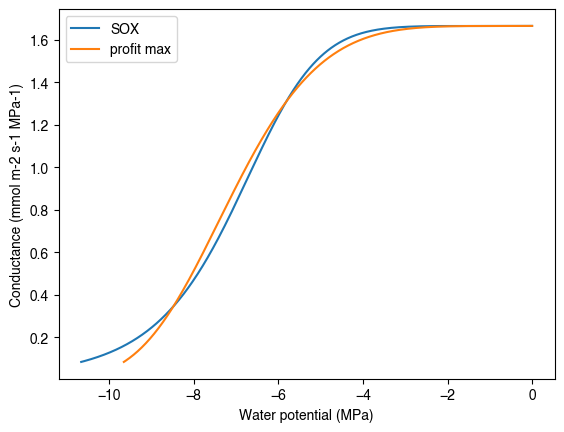

In [3]:
# Conductance model
profit_max_hydraulic_conductance_model = \
    CumulativeWeibullDistribution(maximum_conductance = 1.6659, # mmol m-2 s-1 MPa-1
                                  sensitivity_parameter = -7.740170420442604, # MPa
                                  shape_parameter = 4.969847639573251) # unitless

# Setup leaf water potentials
profit_max_critical_water_potential = profit_max_hydraulic_conductance_model.water_potential_from_conductivity_loss_fraction(critical_conductance_fraction)
profit_max_water_potentials = linspace(0, profit_max_critical_water_potential, 1000)

# calculate conductance
profit_max_hydraulic_conductance = profit_max_hydraulic_conductance_model.conductance(profit_max_water_potentials)

plt.plot(SOX_water_potentials, SOX_hydraulic_conductance, label = "SOX")
plt.plot(profit_max_water_potentials, profit_max_hydraulic_conductance, label = "profit max")
plt.xlabel("Water potential (MPa)")
plt.ylabel("Conductance (mmol m-2 s-1 MPa-1)")
plt.legend()
plt.show()

# Building the SOX model

Having defined the conductance equation used by SOX we can now build the model.

## Hydraulic cost model

In [4]:
SOX_hydraulic_cost_model = SOXHydraulicCostModel(hydraulic_conductance_model = SOX_hydraulic_conductance_model,
                                                 critical_leaf_water_potential = SOX_critical_water_potential)

## Leaf air coupling

In [5]:
leaf_air_coupling_model = LeafAirCouplingModel()

## Photosynthesis model
### Rubisco rate limited

In [6]:
# -- Rubisco rates model --
maximum_carboxylation_rate_model = PeakedArrheniusModel(rate_at_25_centigrade = 30.,
                                                        activation_energy = 60000.,
                                                        deactivation_energy = 200000.,
                                                        entropy_term = 650.)

maximum_oxegentation_rate_model = PeakedArrheniusModel(rate_at_25_centigrade = 60.,
                                                       activation_energy = 30000.,
                                                       deactivation_energy = 200000.,
                                                       entropy_term = 650.)

michaelis_menten_constant_CO2_model = ArrheniusModel(rate_at_25_centigrade=404.9,
                                                     activation_energy=79430.0)

michaelis_menten_constant_O_model = ArrheniusModel(rate_at_25_centigrade=278.4,
                                                   activation_energy=36380.0)

rubisco_rates_model = RubiscoRates(maximum_carboxylation_rate_model,
                                   maximum_oxegentation_rate_model,
                                   michaelis_menten_constant_CO2_model,
                                   michaelis_menten_constant_O_model)

# -- CO2 compensation point --
CO2_compensation_point_model = ArrheniusModel(rate_at_25_centigrade = 42.75,
                                              activation_energy = 37830.0)

# -- mitochondrial respiration rate model --
mitochondrial_respiration_rate_model = Q10TemperatureDependenceModel(value_at_25C = 0.6,
                                                                     Q10_parameter = 2.)

# -- Rubisco limited model --
photosynthesis_rubisco_limited_model = PhotosynthesisModelRubiscoLimited(rubisco_rates_model = rubisco_rates_model,
                                                                         CO2_compensation_point_model = CO2_compensation_point_model,
                                                                         mitochondrial_respiration_rate_model = mitochondrial_respiration_rate_model)

### Electron transport limited model

In [7]:
# -- Electron transport rate --
maximum_electron_transport_rate_model = LowTemperatureAdjustedModel(PeakedArrheniusModel(rate_at_25_centigrade = 60., 
                                                                                         activation_energy = 30000., 
                                                                                         deactivation_energy = 200000., 
                                                                                         entropy_term = 650.),
                                                                   lower_bound_C = 0.,
                                                                   upper_bound_C = 10.)

electron_transport_rate_model = ElectronTransportRateModel(curvature_parameter = 0.85,
                                                           maximum_electron_transport_rate_model = maximum_electron_transport_rate_model)

# -- Electron transport rate limmited model --
# Note the CO2 compensation point and mitochondrial respiration rate models are the same as that for the Rubisco limited model
photosynthesis_electron_transport_limited_model = PhotosynthesisModelElectronTransportLimited(electron_transport_rate_model = electron_transport_rate_model,
                                                                                              CO2_compensation_point_model = CO2_compensation_point_model,
                                                                                              mitochondrial_respiration_rate_model = mitochondrial_respiration_rate_model,
                                                                                              rubisco_rates_model=rubisco_rates_model)

### Combined model

In [8]:
photosynthesis_model = PhotosynthesisModel(photosynthesis_rubisco_limited_model = photosynthesis_rubisco_limited_model,
                                           photosynthesis_electron_transport_limited_model = photosynthesis_electron_transport_limited_model)

## CO2 gain model

In [9]:
SOX_CO2_gain_model = SOXCO2GainModel(leaf_air_coupling_model,
                                     photosynthesis_model)

## SOX model

In [10]:
SOX_model = SOXModel(SOX_hydraulic_cost_model,
                     leaf_air_coupling_model,
                     SOX_CO2_gain_model)

# Running the Model

Let us run the model for a given set of conditions and plot $A_{net}(\psi_l)k(\psi_l)$ as a function of $\psi_l$ to see how the model works.

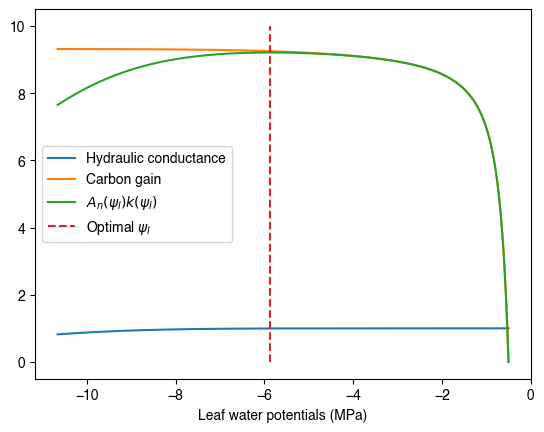

In [11]:
soil_water_potential = -0.5 # MPa
air_temperature = degrees_centigrade_to_kelvin(25.)
air_vapour_pressure_deficit = 1 # kPa
air_pressure = 101.9 # kPa
atmospheric_CO2_concentration = 419. # (umol mol-1)
intercellular_oxygen = 210.0 #(umol mol-1)
photosynthetically_active_radiation = 500. #(umol m-2 s-1)
number_of_sample_points = 10000

SOX_profit, SOX_CO2_gain, SOX_hydraulic_costs, SOX_CO2_uptake, __, SOX_ci, __, SOX_water_potentials = \
    SOX_model.profit_as_a_function_of_leaf_water_potential(soil_water_potential,
                                                           air_temperature,
                                                           air_vapour_pressure_deficit,
                                                           air_pressure,
                                                           atmospheric_CO2_concentration,
                                                           intercellular_oxygen,
                                                           photosynthetically_active_radiation,
                                                           number_of_sample_points)

SOX_maximum_profit_id = nanargmax(SOX_profit)
SOX_optimal_leaf_water_potential = SOX_water_potentials[SOX_maximum_profit_id]
SOX_optimal_ci = SOX_ci[SOX_maximum_profit_id]

plt.plot(SOX_water_potentials, 1 - SOX_hydraulic_costs, label = "Hydraulic conductance")
plt.plot(SOX_water_potentials, SOX_CO2_gain, label = "Carbon gain")
plt.plot(SOX_water_potentials, SOX_profit, label = "$A_n(\psi_l)k(\psi_l)$")
plt.plot([SOX_optimal_leaf_water_potential, SOX_optimal_leaf_water_potential], [0,10], linestyle='--', label = "Optimal $\psi_l$")
plt.legend()
plt.xlabel("Leaf water potentials (MPa)")
plt.ylabel("")
plt.show()

To make comparison easier later and to improve the readablility of the hydraulic cost we will normalise $A_{net}$ by dividing by it's maximum value. This will not impact the optimal leaf water potential as it is just re-scaling.

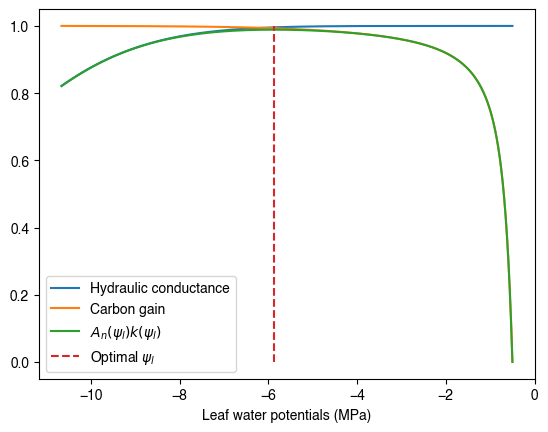

In [12]:
SOX_max_CO2_uptake = nanmax(SOX_CO2_uptake)

SOX_profit /= SOX_max_CO2_uptake
SOX_CO2_gain /= SOX_max_CO2_uptake

plt.plot(SOX_water_potentials, 1 - SOX_hydraulic_costs, label = "Hydraulic conductance")
plt.plot(SOX_water_potentials, SOX_CO2_gain, label = "Carbon gain")
plt.plot(SOX_water_potentials, SOX_profit, label = "$A_n(\psi_l)k(\psi_l)$")
plt.plot([SOX_optimal_leaf_water_potential, SOX_optimal_leaf_water_potential], [0,1], linestyle='--', label = "Optimal $\psi_l$")
plt.legend()
plt.xlabel("Leaf water potentials (MPa)")
plt.ylabel("")
plt.show()

# Building the profit max model

In order to plot comparisons we also want to build the profit max model. We will, where possible, share components used in the SOX model to make comparison as easy as possible.

## Hydraulic cost model

In [13]:
profit_max_hydraulic_cost_model = ProfitMaxHydraulicCostModel(hydraulic_conductance_model = profit_max_hydraulic_conductance_model,
                                                              critical_leaf_water_potential = profit_max_critical_water_potential)

## CO2 gain model

In [14]:
profit_max_CO2_gain_model = ProfitMaxCO2GainModel(leaf_air_coupling_model,
                                                  photosynthesis_model)

# Profit Max Model

In [15]:
profit_max_model = ProfitMaxModel(profit_max_hydraulic_cost_model,
                                  leaf_air_coupling_model,
                                  profit_max_CO2_gain_model)

# Run Profit Max model

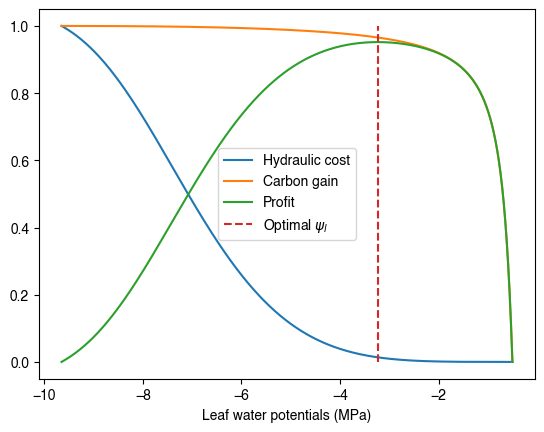

In [16]:
profit_max_profit, profit_max_CO2_gain, profit_max_hydraulic_costs, profit_max_CO2_uptake, __, profit_max_ci, __, profit_max_water_potentials = \
    profit_max_model.profit_as_a_function_of_leaf_water_potential(soil_water_potential,
                                                                  air_temperature,
                                                                  air_vapour_pressure_deficit,
                                                                  air_pressure,
                                                                  atmospheric_CO2_concentration,
                                                                  intercellular_oxygen,
                                                                  photosynthetically_active_radiation,
                                                                  number_of_sample_points)

profit_max_maximum_profit_id = nanargmax(profit_max_profit)
profit_max_optimal_leaf_water_potential = profit_max_water_potentials[profit_max_maximum_profit_id]
profit_max_optimal_ci = profit_max_ci[profit_max_maximum_profit_id]

plt.plot(profit_max_water_potentials, profit_max_hydraulic_costs, label = "Hydraulic cost")
plt.plot(profit_max_water_potentials, profit_max_CO2_gain, label = "Carbon gain")
plt.plot(profit_max_water_potentials, profit_max_profit, label = "Profit")
plt.plot([profit_max_optimal_leaf_water_potential, profit_max_optimal_leaf_water_potential], [0,1], linestyle='--', label = "Optimal $\psi_l$")
plt.legend()
plt.xlabel("Leaf water potentials (MPa)")
plt.ylabel("")
plt.show()

# Comparing the two models

For the set of environmental conditions above let us compare the profit as a function of leaf water potential for the SOX and profit max models.

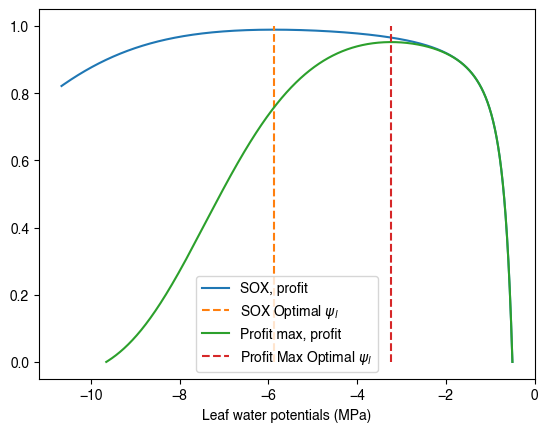

Sox optimal leaf water potential:         -5.877468519053454
Profit max optimal leaf water potential:  -3.2331401748555755


In [17]:
plt.plot(SOX_water_potentials, SOX_profit, label = "SOX, profit")
plt.plot([SOX_optimal_leaf_water_potential, SOX_optimal_leaf_water_potential], [0,1], linestyle='--', label = "SOX Optimal $\psi_l$")

plt.plot(profit_max_water_potentials, profit_max_profit, label = "Profit max, profit")
plt.plot([profit_max_optimal_leaf_water_potential, profit_max_optimal_leaf_water_potential], [0,1], linestyle='--', label = "Profit Max Optimal $\psi_l$")
plt.legend()
plt.xlabel("Leaf water potentials (MPa)")
plt.ylabel("")
plt.show()

print("Sox optimal leaf water potential:        ", SOX_optimal_leaf_water_potential)
print("Profit max optimal leaf water potential: ", profit_max_optimal_leaf_water_potential)

Below we replot the above as a function of $ci/ca$.

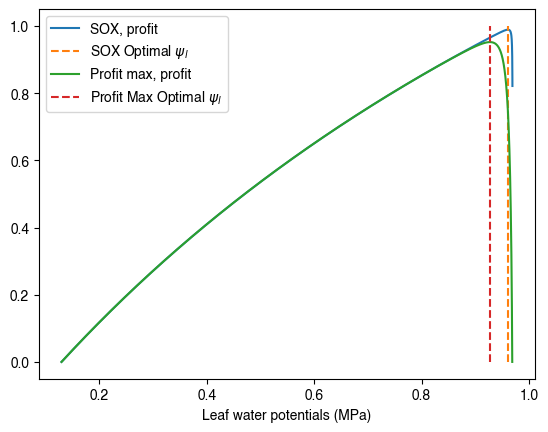

Sox optimal ci over ca:         0.9606625635434253
Profit max optimal ci over ca:  0.9272108385321625


In [18]:
SOX_ci_over_ca = SOX_ci / atmospheric_CO2_concentration
profit_max_ci_over_ca = profit_max_ci / atmospheric_CO2_concentration

SOX_optimal_ci_over_ca = SOX_optimal_ci / atmospheric_CO2_concentration
profit_max_optimal_ci_over_ca = profit_max_optimal_ci / atmospheric_CO2_concentration

plt.plot(SOX_ci_over_ca, SOX_profit, label = "SOX, profit")
plt.plot([SOX_optimal_ci_over_ca, SOX_optimal_ci_over_ca], [0,1], linestyle='--', label = "SOX Optimal $\psi_l$")

plt.plot(profit_max_ci_over_ca, profit_max_profit, label = "Profit max, profit")
plt.plot([profit_max_optimal_ci_over_ca, profit_max_optimal_ci_over_ca], [0,1], linestyle='--', label = "Profit Max Optimal $\psi_l$")
plt.legend()
plt.xlabel("Leaf water potentials (MPa)")
plt.ylabel("")
plt.show()

print("Sox optimal ci over ca:        ", SOX_optimal_ci_over_ca)
print("Profit max optimal ci over ca: ", profit_max_optimal_ci_over_ca)

## Changing the conductance model.

Inspecting the two models the most significant differences occur when the leaf water potential is most negative. Since both models are dominated by the choice of hydraulic conductance at more negative leaf water potentials it is possible that it is the choice of conductance model that is driving the differences. To test this let us remake the SOX model using a cumulative Weibul distribution to model conductance.

In [19]:
SOX_Weibul_hydraulic_cost_model = SOXHydraulicCostModel(hydraulic_conductance_model = profit_max_hydraulic_conductance_model,
                                                 critical_leaf_water_potential = profit_max_critical_water_potential)

SOX_Weibul_model = SOXModel(SOX_Weibul_hydraulic_cost_model,
                            leaf_air_coupling_model,
                            SOX_CO2_gain_model)

Now lets recalculate and plot the updated output of the SOX model.

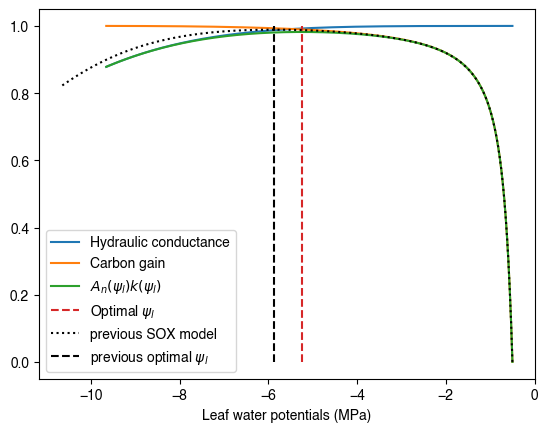

Previous SOX optimal leaf water potential:  -5.877468519053454
SOX optimal leaf water potential:           -5.24592491849503


In [20]:
SOX_Weibul_profit, SOX_Weibul_CO2_gain, SOX_Weibul_hydraulic_costs, SOX_Weibul_CO2_uptake, __, __, __, SOX_Weibul_water_potentials = \
    SOX_Weibul_model.profit_as_a_function_of_leaf_water_potential(soil_water_potential,
                                                                  air_temperature,
                                                                  air_vapour_pressure_deficit,
                                                                  air_pressure,
                                                                  atmospheric_CO2_concentration,
                                                                  intercellular_oxygen,
                                                                  photosynthetically_active_radiation,
                                                                  number_of_sample_points)

SOX_Weibul_maximum_profit_id = nanargmax(SOX_Weibul_profit)
SOX_Weibul_optimal_leaf_water_potential = SOX_Weibul_water_potentials[SOX_Weibul_maximum_profit_id]

SOX_Weibul_max_CO2_uptake = nanmax(SOX_Weibul_CO2_uptake)

SOX_Weibul_profit /= SOX_Weibul_max_CO2_uptake
SOX_Weibul_CO2_gain /= SOX_Weibul_max_CO2_uptake

plt.plot(SOX_Weibul_water_potentials, 1 - SOX_Weibul_hydraulic_costs, label = "Hydraulic conductance")
plt.plot(SOX_Weibul_water_potentials, SOX_Weibul_CO2_gain, label = "Carbon gain")
plt.plot(SOX_Weibul_water_potentials, SOX_Weibul_profit, label = "$A_n(\psi_l)k(\psi_l)$")
plt.plot([SOX_Weibul_optimal_leaf_water_potential, SOX_Weibul_optimal_leaf_water_potential], [0,1], linestyle='--', label = "Optimal $\psi_l$")
plt.plot(SOX_water_potentials, SOX_profit, label = "previous SOX model", linestyle=':', c = 'black')
plt.plot([SOX_optimal_leaf_water_potential, SOX_optimal_leaf_water_potential], [0,1], linestyle='--', label = "previous optimal $\psi_l$", c = 'black')
plt.legend()
plt.xlabel("Leaf water potentials (MPa)")
plt.ylabel("")
plt.show()

print("Previous SOX optimal leaf water potential: ", SOX_optimal_leaf_water_potential)
print("SOX optimal leaf water potential:          ", SOX_Weibul_optimal_leaf_water_potential)

It is clear that changing the hydraulic conductance model has both significantly changed the SOX output for more negative water potentials and shifted the optimal leaf water potential to a smaller value. Let us now compare this new version of the SOX output to that for the profit max model.

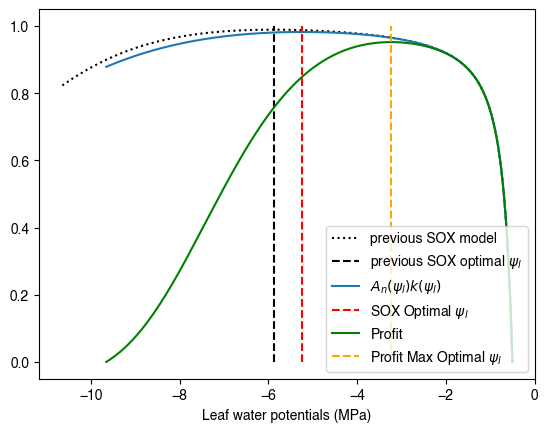

Previous SOX optimal leaf water potential:  -5.877468519053454
SOX optimal leaf water potential:           -5.24592491849503
Profit max optimal leaf water potential:    -3.2331401748555755


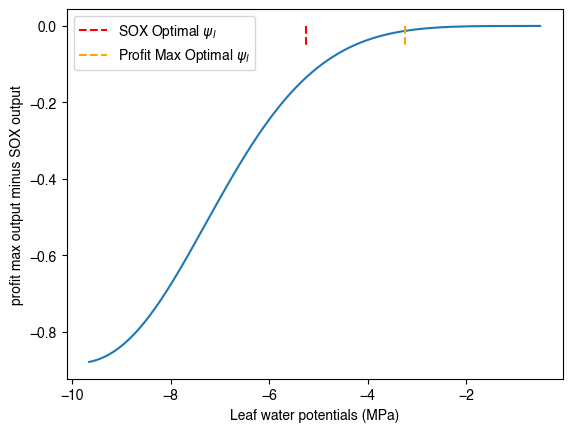

In [21]:
plt.plot(SOX_water_potentials, SOX_profit, label = "previous SOX model", linestyle=':', c = 'black')
plt.plot([SOX_optimal_leaf_water_potential, SOX_optimal_leaf_water_potential], [0,1], linestyle='--', label = "previous SOX optimal $\psi_l$", c = 'black')
plt.plot(SOX_Weibul_water_potentials, SOX_Weibul_profit, label = "$A_n(\psi_l)k(\psi_l)$")
plt.plot([SOX_Weibul_optimal_leaf_water_potential, SOX_Weibul_optimal_leaf_water_potential], [0,1], linestyle='--', label = "SOX Optimal $\psi_l$", c = "red")

plt.plot(profit_max_water_potentials, profit_max_profit, label = "Profit", c = "green")
plt.plot([profit_max_optimal_leaf_water_potential, profit_max_optimal_leaf_water_potential], [0,1], linestyle='--', label = "Profit Max Optimal $\psi_l$", c = "orange")
plt.legend()
plt.xlabel("Leaf water potentials (MPa)")
plt.ylabel("")
plt.show()


print("Previous SOX optimal leaf water potential: ", SOX_optimal_leaf_water_potential)
print("SOX optimal leaf water potential:          ", SOX_Weibul_optimal_leaf_water_potential)
print("Profit max optimal leaf water potential:   ", profit_max_optimal_leaf_water_potential)

plt.plot(SOX_Weibul_water_potentials, profit_max_profit - SOX_Weibul_profit)
plt.plot([SOX_Weibul_optimal_leaf_water_potential, SOX_Weibul_optimal_leaf_water_potential], [0,-0.05], linestyle='--', label = "SOX Optimal $\psi_l$", c = "red")
plt.plot([profit_max_optimal_leaf_water_potential, profit_max_optimal_leaf_water_potential], [0,-0.05], linestyle='--', label = "Profit Max Optimal $\psi_l$", c = "orange")
plt.legend()
plt.xlabel("Leaf water potentials (MPa)")
plt.ylabel("profit max output minus SOX output")
plt.show()